# Import data and variables

In [1]:
# import python module

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

from tqdm import tqdm
from scipy.fftpack import fft, ifft, fft2, ifft2, fftfreq, fftshift, ifftshift
from sklearn.metrics import r2_score

In [2]:
# import data file

input_file = 'Drill3_1.csv'
x_or_y = 'y'                              # data direction for 1D extraction (type 'x' or 'y')
row_no = 10                               # row no. for 1D data extraction

In [3]:
# choice of characterized surface for point cloud output

charactSurf = 'roughness'                 # 'roughness' or 'waviness'

# in the next cell
  ## for roughness profile: assign lambdaS at lambdaS, lambdaC at lambdaC
  ## for waviness profile: assign lambda C at lambdaS, lambdaF at lambdaC
  ##                       waviness profile will show as roughness profile in visualization graphs

In [4]:
# assign constant

## smoothing Gaussian filter
lambda_s = 1                              # micro-m
freq_s = 1/lambda_s                       # (micro-m)^-1

## cut-off Gaussian filter
lambda_c = 30                             # micro-m
freq_c = 1/lambda_c                       # (micro-m)^-1

## dominant freq
ratio_amp_dom2max_1D = 10                 # %
accept_dom_rSqua_2D = 0.90                  # value from 0 to 1
                                            ## 0 = estimated data 'poorly' fit the reference data
                                            ## 1 = estimated data 'well' fit the reference data

#------------------------------------------------------------------------------------------------------#            
            
## constant for gaussian filter (do not touch)
alfa = 0.4697
beta = 0.2206

In [5]:
# to trim off unusable area
# ex. processed surface (drill, mill), the interested height is only one part of the measured surface
# for surface preview, see section 2.1

trim_command = 'y'                         # 'y' if trim, 'n' if not-trim
trim_min = 400                             # um
trim_max = 900                             # um

In [6]:
# point axis for surface reconstruction

data_pnts_recon = 251                     # point number of the reconstructed surface (include start and end points)
elemsize_recon = 500                      # element size
                                              ## point interval: elemsize_recon/(data_pnts_recon-1) has to be interger  

data_list_recon = np.linspace(0, elemsize_recon, data_pnts_recon)     # numpy.linspace(start, stop, num)
data_len_recon = data_list_recon[-1]
data_interval_recon = data_list_recon[1] - data_list_recon[0]
axis_dist_recon = (0, data_len_recon, 0, data_len_recon)

print(data_list_recon)

[  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206. 208. 210. 212. 214. 216. 218. 220. 222.
 224. 226. 228. 230. 232. 234. 236. 238. 240. 242. 244. 246. 248. 250.
 252. 254. 256. 258. 260. 262. 264. 266. 268. 270. 272. 274. 276. 278.
 280. 282. 284. 286. 288. 290. 292. 294. 296. 298. 300. 302. 304. 306.
 308. 310. 312. 314. 316. 318. 320. 322. 324. 326. 328. 330. 332. 334.
 336. 338. 340. 342. 344. 346. 348. 350. 352. 354. 356. 358. 360. 362.
 364. 366. 368. 370. 372. 374. 376. 378. 380. 382. 384. 386. 388. 390.
 392. 

In [7]:
# area selection from the reconstructed surface
## if same characterized surface but other area selection for data export, rerun only section 7.2.1 to save time 

x_select = 250               # um: first point of the area selection in x-axis
z_select = 120               # um: first point of the area selection in z-axis
                                ## integer, and this number must belong to reconstructed axis in the previous cell 

elemsize_select = 30         # um: size of the selected area
                                ## interger, which make the last number belong to reconstructed axis in the previous cell 
                                ## last number = x_select or z_select + elemsize_select

# Data pre-processing

## Data trimming

In [8]:
# import data
df = pd.read_csv(input_file, usecols=['# X','Y','Z'], skiprows=6)
df = df.rename(index=str, columns={"# X": "X"})

df.head()

X    Y         Z
0  0.0000  0.0 -0.000588
1  1.5625  0.0 -0.000588
2  3.1250  0.0 -0.000588
3  4.6875  0.0 -0.000588
4  6.2500  0.0 -0.000588

In [9]:
# trim input data to be square

x_list = sorted(list(set(df['X'])))
y_list = sorted(list(set(df['Y'])))

x_pnts = len(x_list)
y_pnts = len(y_list)
data_pnts = min(x_pnts, y_pnts)


# no of data point after cut = even

if data_pnts % 2 != 0:
    data_pnts = data_pnts - 1
    
data_list = x_list[0:data_pnts]
data_len = data_list[-1]
    
    
print(x_pnts)
print(y_pnts)
print(data_pnts)

931
932
930


In [10]:
# pivot table

df_raw = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
df_raw = df_raw.iloc[0:data_pnts, 0:data_pnts]

df_raw.iloc[0:5,0:5]

X         0.0000    1.5625    3.1250    4.6875    6.2500
Y                                                       
0.0000 -0.000588 -0.000588 -0.000588 -0.000588 -0.000588
1.5625 -0.000588 -0.000588 -0.000588 -0.000588 -0.000588
3.1250 -0.000588 -0.000588 -0.000588 -0.000588 -0.000588
4.6875 -0.000588 -0.000588 -0.000588 -0.000588 -0.000588
6.2500 -0.000588 -0.000588 -0.000588 -0.000588 -0.000588

In [11]:
# find index of trim_min, trim_max

if trim_command == 'y':

    trim_min_loc = 0
    trim_max_loc = 0

    for i in range(len(data_list)):
        if data_list[i] > trim_min:
            trim_min_loc = i
            break

    for i in range(len(data_list)):
        if data_list[len(data_list)-1-i] < trim_max:
            trim_max_loc = len(data_list)-1-i
            break
    
    if (trim_max_loc - trim_min_loc) % 2 != 0:               # no of data point after cut = even
        trim_min_loc = trim_min_loc + 1

In [12]:
# pivot table

if trim_command == 'y':
    df_2D = df.pivot_table(values='Z', index='Y', columns='X', aggfunc='first')
    df_2D = df_2D.iloc[trim_min_loc:trim_max_loc, trim_min_loc:trim_max_loc]

    df_2D.iloc[0:5,0:5]

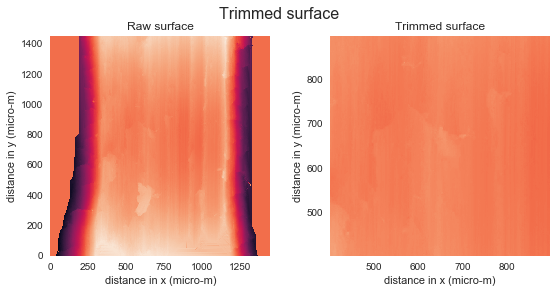

In [13]:
# plot trimmed surface

if trim_command == 'y':

    # set axis
    axis_dist_raw = (0, data_len, 0, data_len)                                          
    axis_dist_2D = (data_list[trim_min_loc], data_list[trim_max_loc], data_list[trim_min_loc], data_list[trim_max_loc])                                         
    v_min_raw = np.amin(df_raw.values)
    v_max_raw = np.amax(df_raw.values)


    plot_size = (8, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle("Trimmed surface", fontsize=16)

    ax1.imshow(df_raw, extent=axis_dist_raw, vmin=v_min_raw, vmax=v_max_raw)
    ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax1.title.set_text('Raw surface')
    ax1.grid(False)

    ax2.imshow(df_2D, extent=axis_dist_2D, vmin=v_min_raw, vmax=v_max_raw) 
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Trimmed surface')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)

In [14]:
# assign spatial axis

if trim_command == 'y':
    
    data_list = x_list[0:trim_max_loc-trim_min_loc]
    data_len = data_list[-1]
    data_pnts = len(data_list)

    print(trim_min_loc)
    print(trim_max_loc)
    print(data_pnts)

257
575
318


In [15]:
if trim_command == 'n':
    df_2D = df_raw.copy()

## Axis assigns

In [16]:
# show spatial axis

print(data_list[0:5], "...", data_list[-5:])
print(data_len)
print(data_pnts)

[0.0, 1.5625, 3.125, 4.6875, 6.25] ... [489.06199999999995, 490.625, 492.18699999999995, 493.75, 495.31199999999995]
495.31199999999995
318


In [17]:
# sampling info

samp_space = data_list[1] - data_list[0]             # micro-m
samp_rate = 1/samp_space                             # (micro-m)^(-1)

print(samp_space)
print(samp_rate)

1.5625
0.64


In [18]:
# assign freq axis

freq_full = fftfreq(data_pnts, samp_space)
freq_full_shift = fftshift(freq_full)
freq_half = freq_full_shift[freq_full_shift >= 0]

print(freq_full[0:5], "...", freq_full[-5:])
print(freq_full_shift[0:5], "...", freq_full_shift[-5:])
print(freq_half[0:5], "...", freq_half[-5:])

[0.         0.00201258 0.00402516 0.00603774 0.00805031] ... [-0.01006289 -0.00805031 -0.00603774 -0.00402516 -0.00201258]
[-0.32       -0.31798742 -0.31597484 -0.31396226 -0.31194969] ... [0.30993711 0.31194969 0.31396226 0.31597484 0.31798742]
[0.         0.00201258 0.00402516 0.00603774 0.00805031] ... [0.30993711 0.31194969 0.31396226 0.31597484 0.31798742]


## Extract row of data (1D)

In [19]:
# check selection in x or y direction
# extract out row of data

if x_or_y == 'x':
    z_data = df_2D.iloc[:, row_no].values
        
if x_or_y == 'y':
    z_data = df_2D.iloc[row_no, :].values

# Gaussian filter

## 1D-Gaussian

In [20]:
# create gaussian 1D

df_gauss_1D = pd.DataFrame(data = freq_full_shift, columns = ['freq']) 
df_gauss_1D['f_to_fc'] = df_gauss_1D['freq'] / freq_c
df_gauss_1D['low_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fc'])**2)
df_gauss_1D['high_gauss'] = 1 - df_gauss_1D['low_gauss']

df_gauss_1D.head()

freq   f_to_fc     low_gauss  high_gauss
0 -0.320000 -9.600000  1.816675e-28         1.0
1 -0.317987 -9.539623  4.046877e-28         1.0
2 -0.315975 -9.479245  8.969495e-28         1.0
3 -0.313962 -9.418868  1.977978e-27         1.0
4 -0.311950 -9.358491  4.339905e-27         1.0

In [21]:
low_gauss_1D = df_gauss_1D['low_gauss'].values
high_gauss_1D = df_gauss_1D['high_gauss'].values

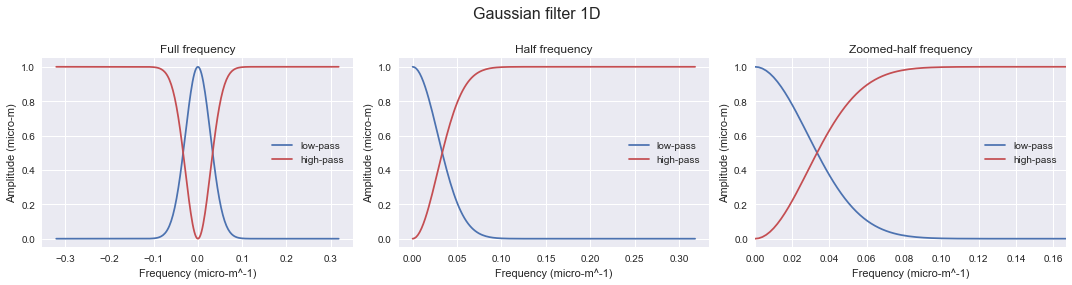

In [22]:
plot_size = (15, 4)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Gaussian filter 1D", fontsize=16)

ax1.plot(freq_full_shift, low_gauss_1D, 'b')
ax1.plot(freq_full_shift, high_gauss_1D, 'r')
ax1.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax1.title.set_text('Full frequency')
ax1.legend(('low-pass','high-pass'), loc='center right')

ax2.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax2.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax2.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax2.title.set_text('Half frequency')
ax2.legend(('low-pass','high-pass'), loc='center right')

ax3.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
ax3.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
ax3.set_xlim(0, freq_c*5)
ax3.set(xlabel='Frequency (micro-m^-1)', ylabel='Amplitude (micro-m)')
ax3.title.set_text('Zoomed-half frequency')
ax3.legend(('low-pass','high-pass'), loc='center right')

plt.tight_layout()
f.subplots_adjust(top=0.8)

## 1D-Gaussian smoothing filter

In [23]:
# create gaussian smoothing filter 1D

df_gauss_1D['f_to_fs'] = df_gauss_1D['freq'] / freq_s
df_gauss_1D['smooth_gauss'] = np.exp(-np.pi * (alfa * df_gauss_1D['f_to_fs'])**2)

df_gauss_1D.head()

freq   f_to_fc     low_gauss  high_gauss   f_to_fs  smooth_gauss
0 -0.320000 -9.600000  1.816675e-28         1.0 -0.320000      0.931487
1 -0.317987 -9.539623  4.046877e-28         1.0 -0.317987      0.932317
2 -0.315975 -9.479245  8.969495e-28         1.0 -0.315975      0.933142
3 -0.313962 -9.418868  1.977978e-27         1.0 -0.313962      0.933962
4 -0.311950 -9.358491  4.339905e-27         1.0 -0.311950      0.934778

In [24]:
smooth_gauss_1D = df_gauss_1D['smooth_gauss'].values

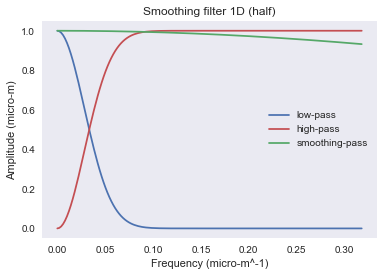

In [25]:
plt.title('Smoothing filter 1D (half)')

plt.plot(freq_half, low_gauss_1D[data_pnts//2:], 'b')
plt.plot(freq_half, high_gauss_1D[data_pnts//2:], 'r')
plt.plot(freq_half, smooth_gauss_1D[data_pnts//2:], 'g')

plt.ylabel('Amplitude (micro-m)')
plt.xlabel('Frequency (micro-m^-1)')
plt.legend(('low-pass','high-pass','smoothing-pass'), loc='center right')

plt.grid()
plt.show()

## 2D-Gaussian

In [26]:
# prepare fx/fc and fy/fc to put in equation

df_fx = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fx.iloc[i,:] = freq_full_shift                             # row by rows
    

df_fy = pd.DataFrame(np.zeros((data_pnts, data_pnts)))

for i in range(data_pnts):
    df_fy.iloc[:,i] = freq_full_shift                             # column by columns


df_fx2fc = df_fx.copy() / freq_c
df_fy2fc = df_fy.copy() / freq_c

In [27]:
# input fx/fc and fy/fc to compute Gaussian

df_low_gauss = np.exp(-np.pi * beta * (df_fx2fc.pow(2) + df_fy2fc.pow(2)))
df_high_gauss = 1 - df_low_gauss

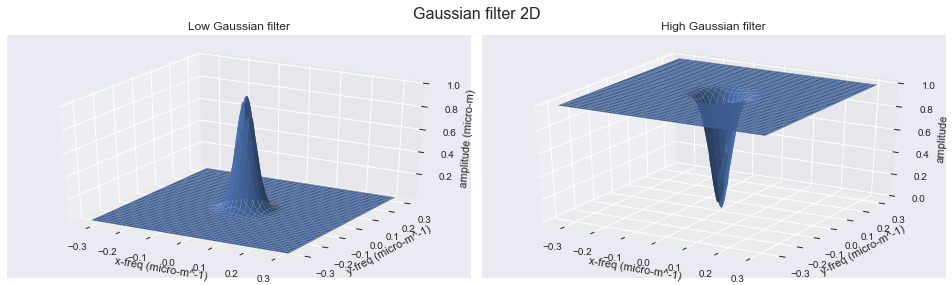

In [28]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Gaussian filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_low_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Low Gaussian filter')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_high_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude')
ax.title.set_text('High Gaussian filter')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 2D-Gaussian smoothing filter

In [29]:
# prepare fx/fc and fy/fc to put in equation

df_fx2fs = df_fx.copy() / freq_s
df_fy2fs = df_fy.copy() / freq_s

In [30]:
# input fx/fc and fy/fc to compute Gaussian

df_smooth_gauss = np.exp(-np.pi * beta * (df_fx2fs.pow(2) + df_fy2fs.pow(2)))

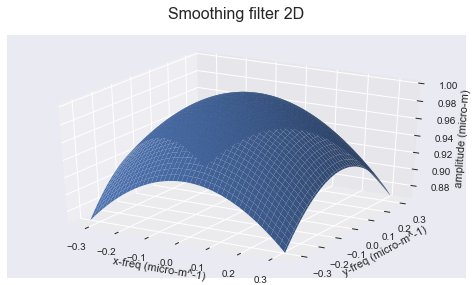

In [31]:
fig = plt.figure(figsize=plt.figaspect(0.6))
fig.suptitle('Smoothing filter 2D', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 1, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = df_smooth_gauss

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# Surface transformation

## 1D-data

### Fourier transform

In [32]:
z_fou_1D = fft(z_data) 
z_inv_1D = ifft(z_fou_1D)

In [33]:
# shift freq domain to multiply with Gaussian

z_fou_1D_shift = fftshift(z_fou_1D)


# amplitude of z-fourier

z_fou_1D_full = 1/data_pnts * abs(z_fou_1D_shift)
z_fou_1D_half = 2/data_pnts * abs(z_fou_1D[0:data_pnts//2])    # fourier amplitude correction
                                                               # [0:data_pnts//2] : to cut only positive half of freq
                                                               # abs() : to get magnitude
                                                               # /data_pnts : to normalized operation of FFT summation
                                                               # *2 : to supplement value of f negative to f positive

In [34]:
# set limit for graph plot (1D)

plt_dist_xlim_1D = data_len
plt_dist_zlim_1D = max(np.amax(z_data), abs(np.amin(z_data))) * 1.3
plt_freq_xlim_1D = samp_rate
plt_freq_zlim_1D = np.amax(z_fou_1D_half) * 1.3

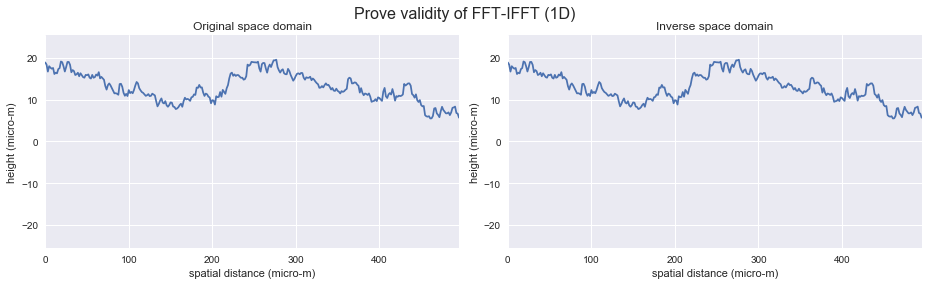

In [35]:
# prove validity of Fourier transform after cut outlier

plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Original space domain')

ax2.plot(data_list, z_inv_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Inverse space domain')

plt.tight_layout()
f.subplots_adjust(top=0.88)

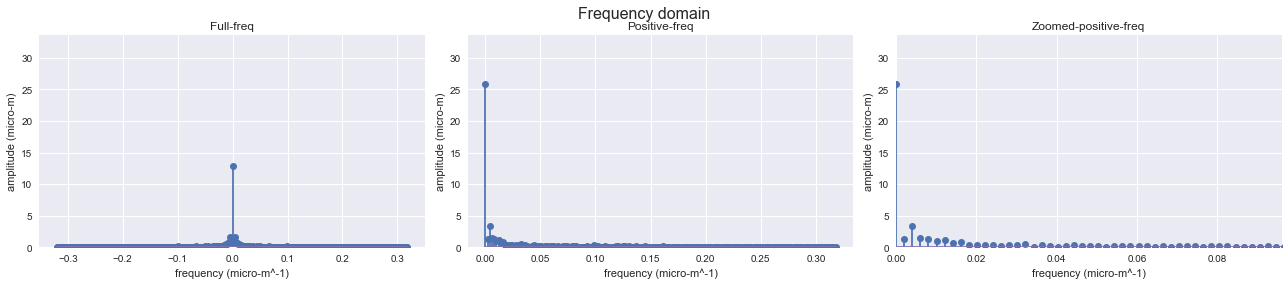

In [36]:
# plot freq domain

plot_size = (18, 4)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Frequency domain", fontsize=16)

ax1.stem(freq_full_shift, z_fou_1D_full)
ax1.set_ylim(0, plt_freq_zlim_1D)
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full-freq')

ax2.stem(freq_half, z_fou_1D_half)
ax2.set_ylim(0, plt_freq_zlim_1D)
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Positive-freq')

ax3.stem(freq_half, z_fou_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.15)
ax3.set_ylim(0, plt_freq_zlim_1D)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('Zoomed-positive-freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [37]:
# compare result

rSq_fft_1D = r2_score(z_data, z_inv_1D.real)

print('Prove validity of Fourier transform 1D')
print('R-square: ', rSq_fft_1D)

Prove validity of Fourier transform 1D
R-square:  1.0


### Smoothing filter

In [38]:
# assign dataframe for operation

df_conv_1D = pd.DataFrame(data=freq_full_shift, columns=['freq'])
df_conv_1D['z_fou'] = z_fou_1D_shift
df_conv_1D['low_gauss'] = low_gauss_1D
df_conv_1D['high_gauss'] = high_gauss_1D
df_conv_1D['smooth_gauss'] = smooth_gauss_1D

In [39]:
df_conv_1D['smooth_conv'] = df_conv_1D['z_fou'] * df_conv_1D['smooth_gauss']

df_conv_1D.head()

freq                                     z_fou     low_gauss  \
0 -0.320000                    (8.953140000000076+0j)  1.816675e-28   
1 -0.317987   (7.037292268602926-0.1830530478817316j)  4.046877e-28   
2 -0.315975    (4.7557513112490994+5.01171226274019j)  8.969495e-28   
3 -0.313962  (13.804139678602851+1.1095448114255362j)  1.977978e-27   
4 -0.311950   (8.775861329424883+2.0670948168598784j)  4.339905e-27   

   high_gauss  smooth_gauss                               smooth_conv  
0         1.0      0.931487                    (8.339736911230979+0j)  
1         1.0      0.932317   (6.560985151377811-0.1706634147376292j)  
2         1.0      0.933142   (4.4377890711269465+4.676636865896112j)  
3         1.0      0.933962  (12.892539776837483+1.0362725203121963j)  
4         1.0      0.934778   (8.203478865447757+1.9322739964144233j)

In [40]:
# shift freq domain back for IFFT operation

z_fou_1D_ishift = ifftshift(df_conv_1D['z_fou'].values)
z_fou_smooth_1D_ishift = ifftshift(df_conv_1D['smooth_conv'].values)

In [41]:
# correct freq amplitude for graph plot

z_fou_smooth_1D_full = 1/data_pnts * abs(z_fou_smooth_1D_ishift)
z_fou_smooth_1D_half = 2/data_pnts * abs(z_fou_smooth_1D_ishift[0:data_pnts//2])

In [42]:
# inverse Fourier transform

z_inv_1D = ifft(z_fou_1D_ishift)
z_inv_smooth_1D = ifft(z_fou_smooth_1D_ishift)

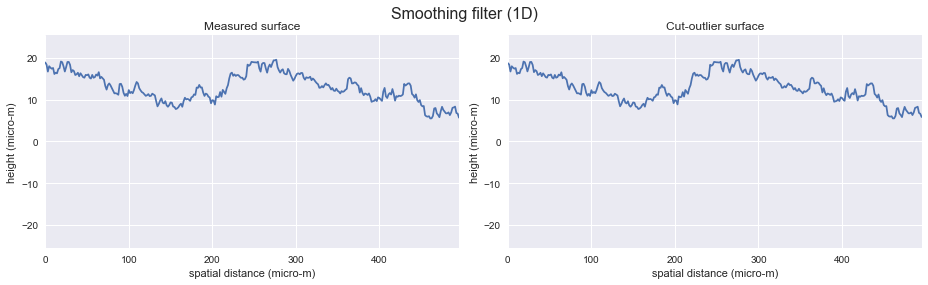

In [43]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Smoothing filter (1D)", fontsize=16)

ax1.plot(data_list, z_data)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Measured surface')

ax2.plot(data_list, z_inv_smooth_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Cut-outlier surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [44]:
# compare result

rSq_ori_corr_1D = r2_score(z_data, z_inv_smooth_1D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_1D)

Original to cut-outlier surface
R-square:  0.9999711804582944


### Waviness-Roughness filter

In [45]:
# convolution by mulplication in freq domain

df_conv_1D['low_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['low_gauss']
df_conv_1D['high_conv'] = df_conv_1D['smooth_conv'] * df_conv_1D['high_gauss']

df_conv_1D.head()

freq                                     z_fou     low_gauss  \
0 -0.320000                    (8.953140000000076+0j)  1.816675e-28   
1 -0.317987   (7.037292268602926-0.1830530478817316j)  4.046877e-28   
2 -0.315975    (4.7557513112490994+5.01171226274019j)  8.969495e-28   
3 -0.313962  (13.804139678602851+1.1095448114255362j)  1.977978e-27   
4 -0.311950   (8.775861329424883+2.0670948168598784j)  4.339905e-27   

   high_gauss  smooth_gauss                               smooth_conv  \
0         1.0      0.931487                    (8.339736911230979+0j)   
1         1.0      0.932317   (6.560985151377811-0.1706634147376292j)   
2         1.0      0.933142   (4.4377890711269465+4.676636865896112j)   
3         1.0      0.933962  (12.892539776837483+1.0362725203121963j)   
4         1.0      0.934778   (8.203478865447757+1.9322739964144233j)   

                                           low_conv  \
0                       (1.5150595134762658e-27+0j)   
1    (2.655149684967224e-27-6.906537683306414e-29j)   
2   (3.980472544952097e-27+4.1947069473230025e-27j)   
3  (2.5501157147819088e-26+2.0497240144974876e-27j)   
4    (3.560232100243137e-26+8.385886062893196e-27j)   

                                  high_conv  
0                    (8.339736911230979+0j)  
1   (6.560985151377811-0.1706634147376292j)  
2   (4.4377890711269465+4.676636865896112j)  
3  (12.892539776837483+1.0362725203121963j)  
4   (8.203478865447757+1.9322739964144233j)

In [46]:
# shift freq domain back for IFFT operation

z_fou_low_1D_ishift = ifftshift(df_conv_1D['low_conv'].values)
z_fou_high_1D_ishift = ifftshift(df_conv_1D['high_conv'].values)

In [47]:
# correct freq amplitude for graph plot

z_fou_low_1D_full = 1/data_pnts * abs(z_fou_low_1D_ishift)
z_fou_low_1D_half = 2/data_pnts * abs(z_fou_low_1D_ishift[0:data_pnts//2])

z_fou_high_1D_full = 1/data_pnts * abs(z_fou_high_1D_ishift)
z_fou_high_1D_half = 2/data_pnts * abs(z_fou_high_1D_ishift[0:data_pnts//2])

In [48]:
# inverse Fourier transform

z_inv_low_1D = ifft(z_fou_low_1D_ishift)
z_inv_high_1D = ifft(z_fou_high_1D_ishift)

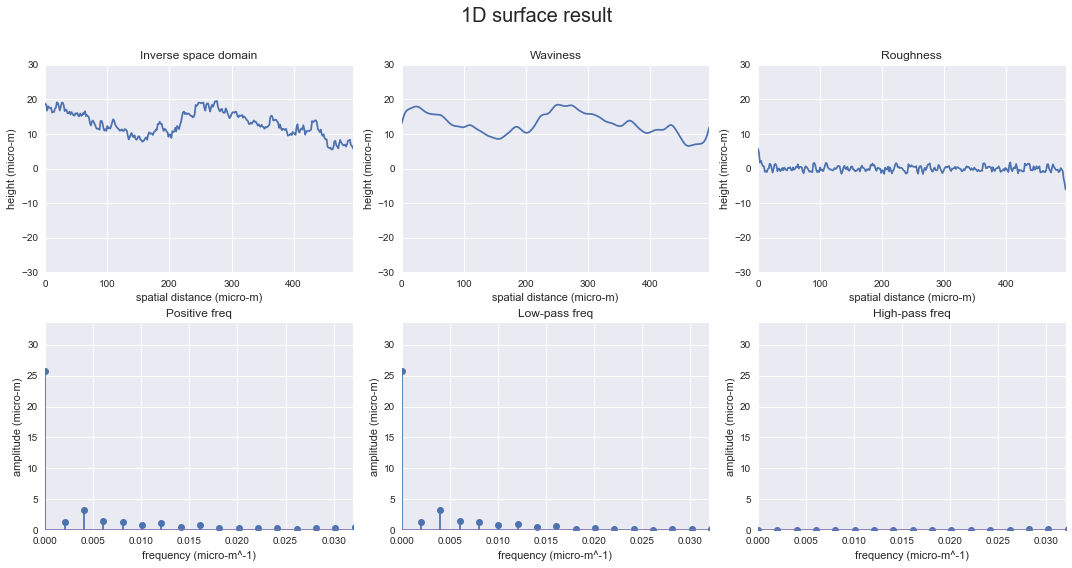

In [49]:
plot_size = (15, 8)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("1D surface result", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-30, 30)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-30, 30)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-30, 30)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness')

ax4.stem(freq_half, z_fou_smooth_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax4.set_ylim(0, plt_freq_zlim_1D)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Positive freq')

ax5.stem(freq_half, z_fou_low_1D_half)
ax5.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax5.set_ylim(0, plt_freq_zlim_1D)
ax5.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax5.title.set_text('Low-pass freq')

ax6.stem(freq_half, z_fou_high_1D_half)
ax6.set_xlim(0, plt_freq_xlim_1D * 0.05)
ax6.set_ylim(0, plt_freq_zlim_1D)
ax6.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax6.title.set_text('High-pass freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

## 2D-data

### Fourier transform

In [50]:
z_fou_2D = fft2(df_2D)
z_inv_2D = ifft2(z_fou_2D)

In [51]:
# shift freq domain to plot graph

z_fou_2D_shift = fftshift(z_fou_2D)

In [52]:
# set limit for graph plot (2D)

axis_dist = (0, data_len, 0, data_len) 
axis_freq = (0, samp_rate, 0, samp_rate)         
v_min_dist = np.amin(z_inv_2D.real)
v_max_dist = np.amax(z_inv_2D.real)
v_min_fAmp = np.amin(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_max_fAmp = np.amax(np.log10(1/data_pnts**2 * abs(z_fou_2D_shift)))
v_min_fPhs = np.amin(np.angle(z_fou_2D_shift))
v_max_fPhs = np.amax(np.angle(z_fou_2D_shift))

plt_dist_xlim_2D = data_len
plt_dist_zlim_2D = max(np.amax(df_2D.values), abs(np.amin(df_2D.values))) * 1.3
plt_freq_xlim_2D = samp_rate
plt_freq_zlim_2D = np.amax(z_fou_2D)/data_pnts**2 * 1.3

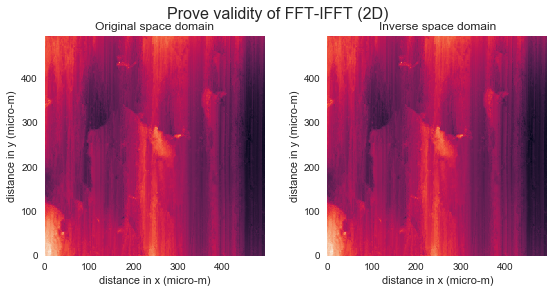

In [53]:
# prove validity of Fourier transform after cut outlier

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Prove validity of FFT-IFFT (2D)", fontsize=16)

ax1.imshow(df_2D, extent=axis_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original space domain')
ax1.grid(False)

ax2.imshow(z_inv_2D.real, extent=axis_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Inverse space domain')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

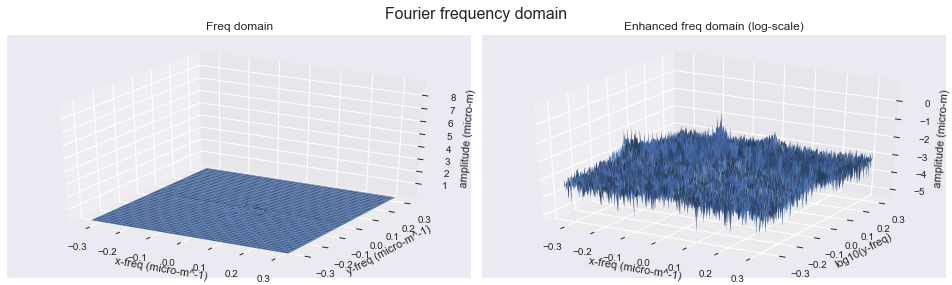

In [54]:
# plot freq domain
# enhance freq domain by log-scale to show difference of freq hight


fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Fourier frequency domain', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_2D_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq domain')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = np.log10(1/data_pnts**2 * abs(z_fou_2D_shift))                   # log10 to enhance value difference

surf = ax.plot_surface(X, Y, Z)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='log10(y-freq)', zlabel='amplitude (micro-m)')
ax.title.set_text('Enhanced freq domain (log-scale)')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [55]:
# compare result

rSq_fft_2D = r2_score(df_2D, z_inv_2D.real)

print('Prove validity of Fourier transform 2D')
print('R-square: ', rSq_fft_2D)

Prove validity of Fourier transform 2D
R-square:  1.0


### Smoothing filter

In [56]:
# smoothing convolution

z_fou_smooth_2D = np.multiply(z_fou_2D_shift, df_smooth_gauss)

In [57]:
# shift freq domain back for IFFT operation

z_fou_2D_ishift = ifftshift(z_fou_2D_shift)
z_fou_smooth_2D_ishift = ifftshift(z_fou_smooth_2D)

In [58]:
# inverse Fourier transform

z_inv_2D = ifft2(z_fou_2D_ishift)
z_inv_smooth_2D = ifft2(z_fou_smooth_2D_ishift)

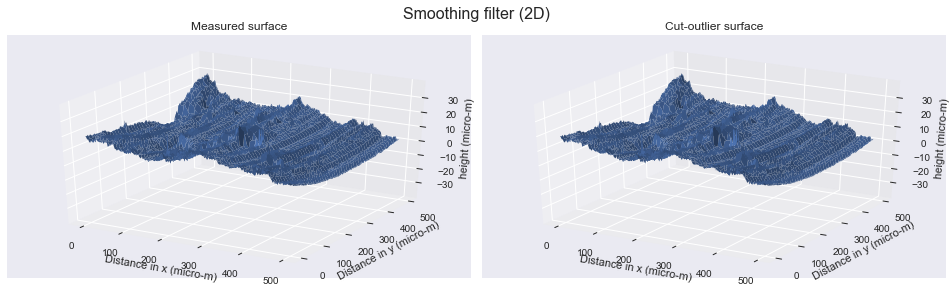

In [59]:
fig = plt.figure(figsize=plt.figaspect(0.3))
fig.suptitle('Smoothing filter (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Measured surface')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Cut-outlier surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [60]:
# compare result

rSq_ori_corr_2D = r2_score(df_2D, z_inv_smooth_2D.real)

print('Original to cut-outlier surface')
print('R-square: ', rSq_ori_corr_2D)

Original to cut-outlier surface
R-square:  0.999929948895283


### Waviness-Roughness filter

In [61]:
# convolution by element-wise mulplication in freq domain

## low-pass convolution
z_fou_low_2D = np.multiply(z_fou_smooth_2D, df_low_gauss)


## high-pass convolution
z_fou_high_2D = np.multiply(z_fou_smooth_2D, df_high_gauss)

In [62]:
# shift freq domain back for IFFT operation

z_fou_low_2D_ishift = ifftshift(z_fou_low_2D)
z_fou_high_2D_ishift = ifftshift(z_fou_high_2D)

In [63]:
# inverse Fourier transform

z_inv_low_2D = ifft2(z_fou_low_2D_ishift)
z_inv_high_2D = ifft2(z_fou_high_2D_ishift)

D:\Program\Python\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


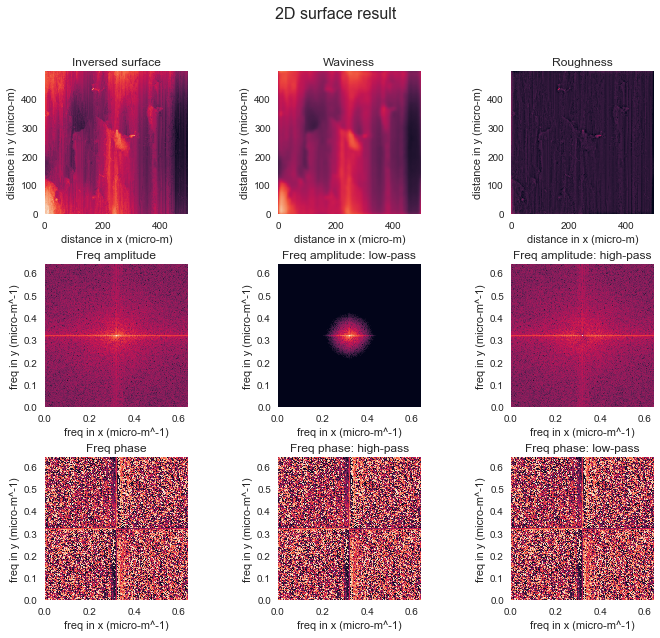

In [64]:
# image plot

plot_size = (10, 9)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=plot_size)
f.suptitle("2D surface result", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Inversed surface')
ax1.grid(False)

ax2.imshow(z_inv_low_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Waviness')
ax2.grid(False)

ax3.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Roughness')
ax3.grid(False)

ax4.imshow(np.log10(1/data_pnts**2 * abs(z_fou_smooth_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)    # log10 to enhance the result
ax4.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax4.title.set_text('Freq amplitude')
ax4.grid(False)

ax5.imshow(np.log10(1/data_pnts**2 * abs(z_fou_low_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax5.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax5.title.set_text('Freq amplitude: low-pass')
ax5.grid(False)

ax6.imshow(np.log10(1/data_pnts**2 * abs(z_fou_high_2D)), extent=axis_freq, vmin=v_min_fAmp, vmax=v_max_fAmp)      # log10 to enhance the result
ax6.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax6.title.set_text('Freq amplitude: high-pass')
ax6.grid(False)

ax7.imshow(np.angle(z_fou_smooth_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax7.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax7.title.set_text('Freq phase')
ax7.grid(False)

ax8.imshow(np.angle(z_fou_low_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax8.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax8.title.set_text('Freq phase: high-pass')
ax8.grid(False)

ax9.imshow(np.angle(z_fou_high_2D), extent=axis_freq, vmin=v_min_fPhs, vmax=v_max_fPhs)    
ax9.set(xlabel='freq in x (micro-m^-1)', ylabel='freq in y (micro-m^-1)')
ax9.title.set_text('Freq phase: low-pass')
ax9.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


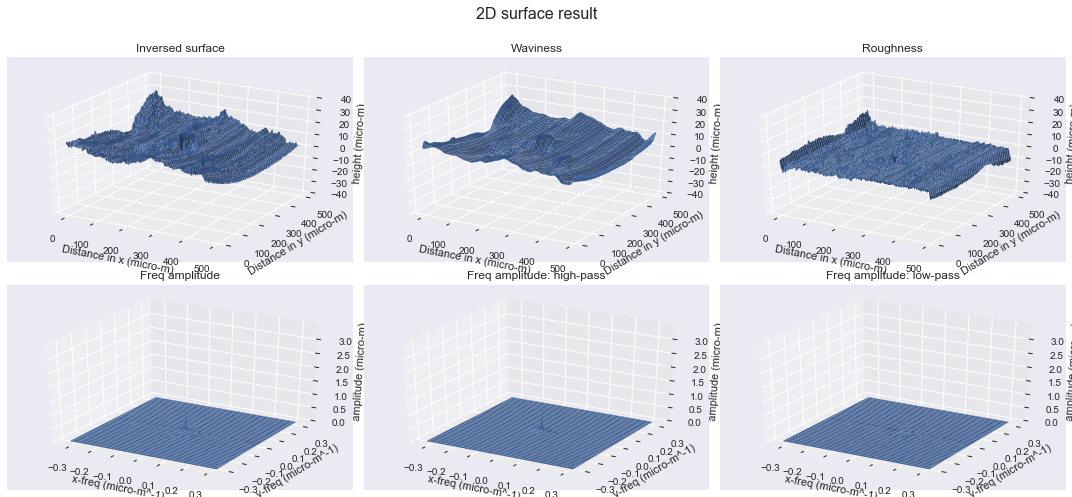

In [65]:
# surface plot

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plot_size = (15, 7)
fig = plt.figure(figsize=plot_size)                                     # set up figure size
fig.suptitle('2D surface result', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.set_zlim(-40, 40)
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.set_zlim(-40, 40)
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.set_zlim(-40, 40)
ax.title.set_text('Roughness')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_low_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: high-pass')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')            

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Freq amplitude: low-pass')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

## 1D and 2D surface comparison

In [66]:
# extract row of 2D surface transformation to compare with 1D surface transformation

if x_or_y == 'x': 
    z_inv_select = z_inv_smooth_2D[:, row_no]
    z_inv_select_low = z_inv_low_2D[:, row_no]
    z_inv_select_high = z_inv_high_2D[:, row_no]
        
if x_or_y == 'y':
    z_inv_select = z_inv_smooth_2D[row_no, :]
    z_inv_select_low = z_inv_low_2D[row_no, :]
    z_inv_select_high = z_inv_high_2D[row_no, :]

D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


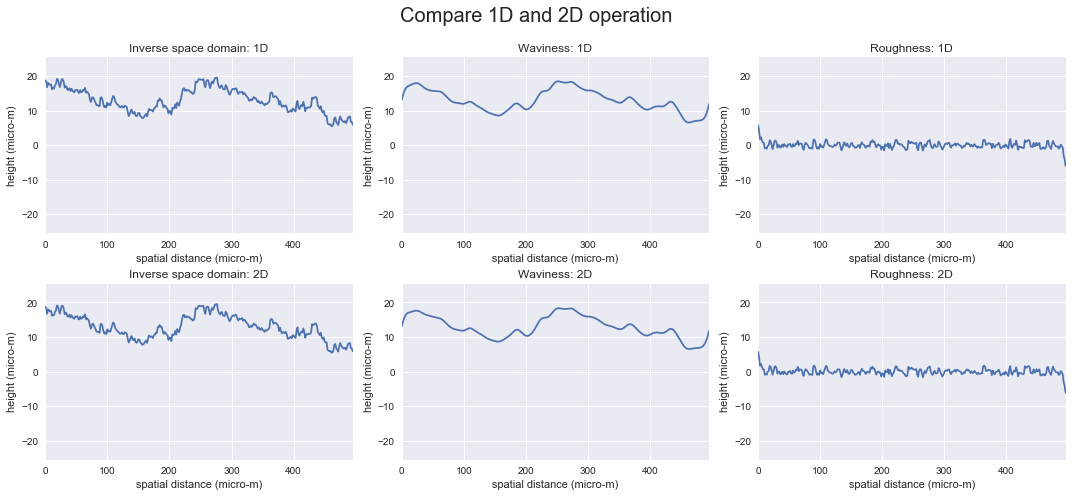

In [67]:
# plot compare 1D and 2D result in 1D-display

plot_size = (15, 7)
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=plot_size)
f.suptitle("Compare 1D and 2D operation", fontsize=20)

ax1.plot(data_list, z_inv_smooth_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Inverse space domain: 1D')

ax2.plot(data_list, z_inv_low_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Waviness: 1D')

ax3.plot(data_list, z_inv_high_1D.real)
ax3.set_xlim(0, plt_dist_xlim_1D)
ax3.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax3.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax3.title.set_text('Roughness: 1D')

ax4.plot(data_list, z_inv_select)
ax4.set_xlim(0, plt_dist_xlim_1D)
ax4.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax4.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax4.title.set_text('Inverse space domain: 2D')

ax5.plot(data_list, z_inv_select_low)
ax5.set_xlim(0, plt_dist_xlim_1D)
ax5.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax5.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax5.title.set_text('Waviness: 2D')

ax6.plot(data_list, z_inv_select_high)
ax6.set_xlim(0, plt_dist_xlim_1D)
ax6.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax6.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax6.title.set_text('Roughness: 2D')


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [68]:
# compare result

rSq_inv_1D2D = r2_score(z_inv_select, z_inv_smooth_1D.real)
rSq_wav_1D2D = r2_score(z_inv_select_low, z_inv_low_1D.real)
rSq_rou_1D2D = r2_score(z_inv_select_high,z_inv_high_1D.real)

print('Inverse space domain - 1D to 2D')
print('R-square: ', rSq_inv_1D2D)
print('\nWaviness - 1D to 2D')
print('R-square: ', rSq_wav_1D2D)
print('\nRoughness - 1D to 2D')
print('R-square: ', rSq_rou_1D2D)

D:\Program\Python\lib\site-packages\numpy\core\_methods.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims)


Inverse space domain - 1D to 2D
R-square:  0.9999970326263709

Waviness - 1D to 2D
R-square:  0.9986350809001249

Roughness - 1D to 2D
R-square:  0.9859063561566093


# Dominant frequency

## 1D dominant freq

In [69]:
# automatically assign cut-off amplitude by ratio to max value of freq

freq_dom_amp_c_1D = ratio_amp_dom2max_1D * z_fou_high_1D_half.max() / 100    # value as shown in graph (half-range)
freq_dom_amp_c_1D_full = freq_dom_amp_c_1D/2                                 # value for extraction operation (full-range)

print(freq_dom_amp_c_1D)
print(freq_dom_amp_c_1D_full)

0.02928986041254934
0.01464493020627467


In [70]:
# create dataframe for operation

df_freq_dom_1D = pd.DataFrame(data=freq_full, columns=['freq'])
df_freq_dom_1D['high_conv'] = z_fou_high_1D_ishift
df_freq_dom_1D['amplitude'] = z_fou_high_1D_full
df_freq_dom_1D['dominant?'] = np.zeros(len(df_freq_dom_1D))
df_freq_dom_1D['f_dom'] = np.zeros(len(df_freq_dom_1D))

In [71]:
# identify dominant freq by boolean True, False

df_freq_dom_1D['dominant?'] = np.where(
    df_freq_dom_1D['amplitude'] >= freq_dom_amp_c_1D_full,
    True,
    False
)


# remain only the value of dominant freq

df_freq_dom_1D['f_dom'] = np.where(
    df_freq_dom_1D['dominant?'] == True,
    df_freq_dom_1D['high_conv'],
    0.0
)

df_freq_dom_1D.head()

freq                                   high_conv  amplitude  dominant?  \
0  0.000000                                          0j   0.000000      False   
1  0.002013  (-0.5394538408958243+0.09106450066928246j)   0.001720      False   
2  0.004025     (2.7753829728730697-4.542033053191533j)   0.016739       True   
3  0.006038    (-4.019626492950959-3.6671271935192746j)   0.017110       True   
4  0.008050      (1.5088257745749518-8.28128347795537j)   0.026470       True   

                                      f_dom  
0                                        0j  
1                                        0j  
2   (2.7753829728730697-4.542033053191533j)  
3  (-4.019626492950959-3.6671271935192746j)  
4    (1.5088257745749518-8.28128347795537j)

In [72]:
# normalized amplitude for graph plot

z_fou_dom_1D_full = 1/data_pnts * abs(df_freq_dom_1D['f_dom'].values)
z_fou_dom_1D_half = 2/data_pnts * abs(df_freq_dom_1D['f_dom'].values[0:data_pnts//2])

In [73]:
# inverse Fourier transform

z_inv_dom_1D = ifft(df_freq_dom_1D['f_dom'].values)

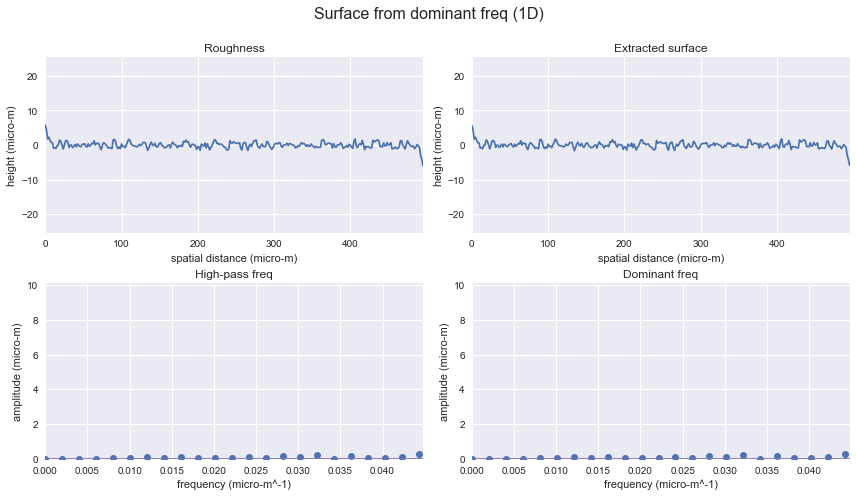

In [74]:
plot_size = (12, 7)
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=plot_size)
f.suptitle("Surface from dominant freq (1D)", fontsize=16)

ax1.plot(data_list, z_inv_high_1D.real)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness')

ax2.plot(data_list, z_inv_dom_1D.real)
ax2.set_xlim(0, plt_dist_xlim_1D)
ax2.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Extracted surface')

ax3.stem(freq_half, z_fou_high_1D_half)
ax3.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax3.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax3.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax3.title.set_text('High-pass freq')

ax4.stem(freq_half, z_fou_dom_1D_half)
ax4.set_xlim(0, plt_freq_xlim_1D * 0.07)
ax4.set_ylim(0, plt_freq_zlim_1D * 0.3)
ax4.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax4.title.set_text('Dominant freq')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [75]:
# count amount of dominant freq 1D
f_dom_no_1D = (df_freq_dom_1D['dominant?'] == True).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no_1D)

Amount of dominant freq:  287


In [76]:
# compare result

rSq_rou2dom_1D = r2_score(z_inv_high_1D.real, z_inv_dom_1D.real)

print('Roughness to Dominant surface 1D')
print('R-square: ', rSq_rou2dom_1D)

Roughness to Dominant surface 1D
R-square:  0.9966310560723618


## 2D dominant freq

### Autimatically assign cut-off amplitude

In [77]:
# prepare dataframe for loop operation

df_freq = pd.DataFrame(data = z_fou_high_2D_ishift,
                       index = freq_full,
                       columns = freq_full)

df_freq_amp = abs(df_freq)

In [78]:
# prepare list of freq -> to find cut-off amplitude of dominant freq

list_freq_amp = df_freq_amp.values.flatten()
list_freq_amp = sorted(list_freq_amp)

In [79]:
# create table to compare result based on amount of dominant freq

# no_dom_freq_per = np.array([0.0025,0.005,0.01,
#                             0.02,0.04,0.06,0.08,0.1,
#                             0.2,0.4,0.6,0.8,1.0,
#                             1.5,2.0,5.0,10.0,20.0,30.0])

no_dom_freq_per = np.array([10.0,20.0,30.0,40.0,50.0,60.0,70.0])

df_dom_samp = pd.DataFrame(data = no_dom_freq_per, columns = ['no_f_per'])
df_dom_samp['no_f'] = df_dom_samp['no_f_per'] * len(list_freq_amp) / 100
df_dom_samp['no_f_int'] = df_dom_samp['no_f'].astype(int) + 1
df_dom_samp['f_dom_amp_c'] = np.zeros(len(no_dom_freq_per))
df_dom_samp['result_error'] = np.zeros(len(no_dom_freq_per))

In [80]:
# find cut-off amplitude for dominant freq

for i in range(len(no_dom_freq_per)):
    df_dom_samp.loc[i,'f_dom_amp_c'] = list_freq_amp[-df_dom_samp.loc[i,'no_f_int']]
    
df_dom_samp.head()

no_f_per     no_f  no_f_int  f_dom_amp_c  result_error
0      10.0  10112.4     10113   305.194682           0.0
1      20.0  20224.8     20225   184.526649           0.0
2      30.0  30337.2     30338   134.651953           0.0
3      40.0  40449.6     40450   106.556535           0.0
4      50.0  50562.0     50563    86.683918           0.0

D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


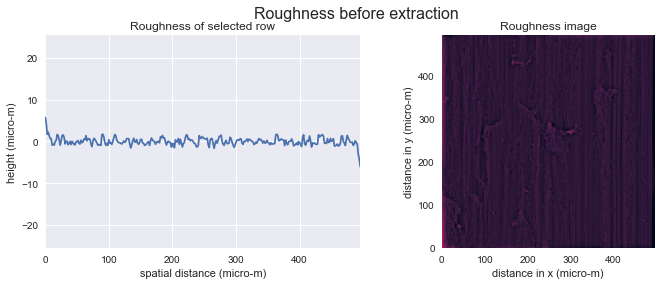

In [81]:
# roughness plot

plot_size = (10, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Roughness before extraction", fontsize=16)

ax1.plot(data_list, z_inv_select_high)
ax1.set_xlim(0, plt_dist_xlim_1D)
ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Roughness of selected row')

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness image')
ax2.grid(False)


plt.tight_layout()
f.subplots_adjust(top=0.88)

In [82]:
def find_error_dom_f(no_f_per, freq_dom_amp_c):

    df_freq_dom = df_freq.copy()
    
    for x in df_freq.columns:
        df_freq_dom[x] = np.where(
            df_freq_amp[x] > freq_dom_amp_c,
            df_freq_dom[x],
            0.0
        )
    
    z_fou_dom = df_freq_dom.values
    z_inv_dom_2D = ifft2(z_fou_dom)

#----------------------------------------------------------------------------------------------------------------------------#
    
    # find error
    
    rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)
    
#----------------------------------------------------------------------------------------------------------------------------#

    # extract row for 1D plot

    if x_or_y == 'x': 
        z_inv_select_dom = z_inv_dom_2D[:, row_no]
        
    if x_or_y == 'y':
        z_inv_select_dom = z_inv_dom_2D[row_no, :]
    
#----------------------------------------------------------------------------------------------------------------------------#

    # plot graph to compare
    
    
    title = 'No. of selected dom freq: ' + str(no_f_per) + ', R-Square error: ' + str("{0:.2f}".format(rSq_rou2dom_2D))
        
    plot_size = (10, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
    f.suptitle(title, fontsize=16)
    axis_dist = (0, data_len, 0, data_len)                                             # assign axis for spatial domain
    axis_freq = (0, samp_rate, 0, samp_rate)                                           # assign axis for freq domain

    ax1.plot(data_list, z_inv_select_dom)
    ax1.set_xlim(0, plt_dist_xlim_1D)
    ax1.set_ylim(-plt_dist_zlim_1D, plt_dist_zlim_1D)
    ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
    ax1.title.set_text('Roughness of selected row')

    ax2.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
    ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
    ax2.title.set_text('Roughness image')
    ax2.grid(False)

    plt.tight_layout()
    f.subplots_adjust(top=0.88)
    
    
    return rSq_rou2dom_2D

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]D:\Program\Python\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.61it/s]


no_f_per     no_f  no_f_int  f_dom_amp_c  result_error
0      10.0  10112.4     10113   305.194682      0.760967
1      20.0  20224.8     20225   184.526649      0.871397
2      30.0  30337.2     30338   134.651953      0.920474
3      40.0  40449.6     40450   106.556535      0.948688
4      50.0  50562.0     50563    86.683918      0.967727
5      60.0  60674.4     60675    70.951755      0.980789
6      70.0  70786.8     70787    57.280838      0.989820

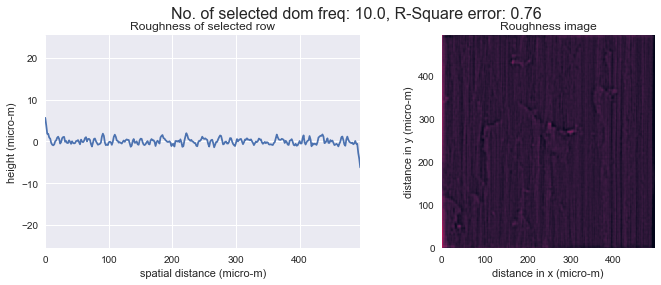

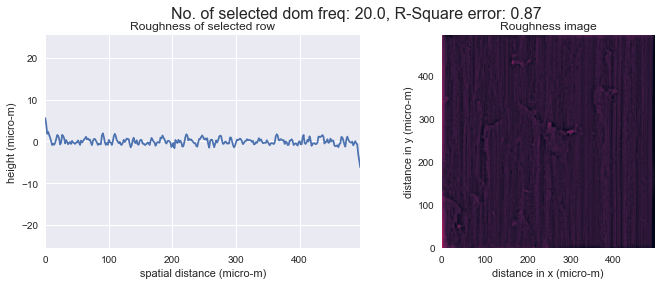

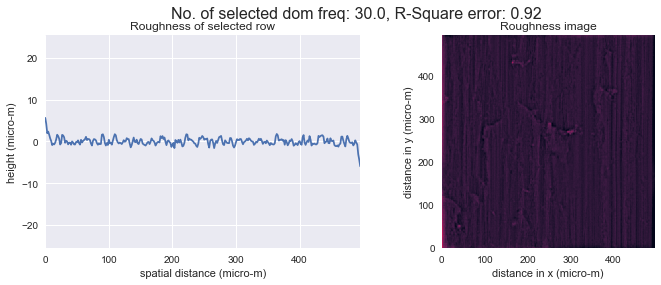

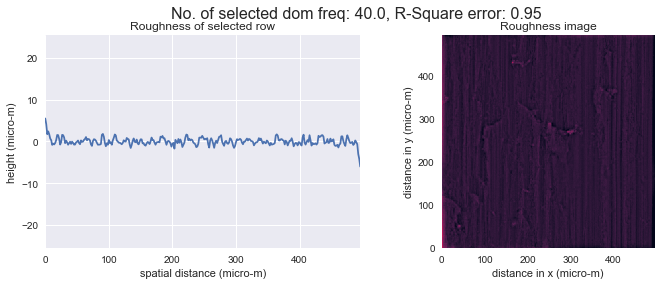

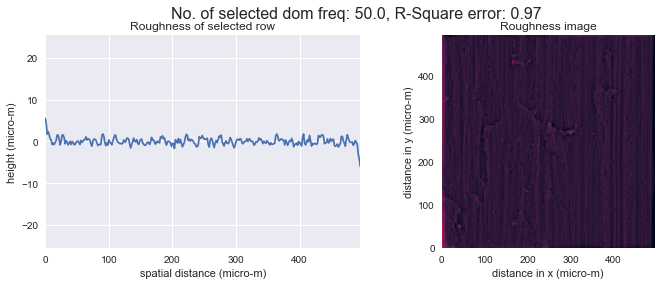

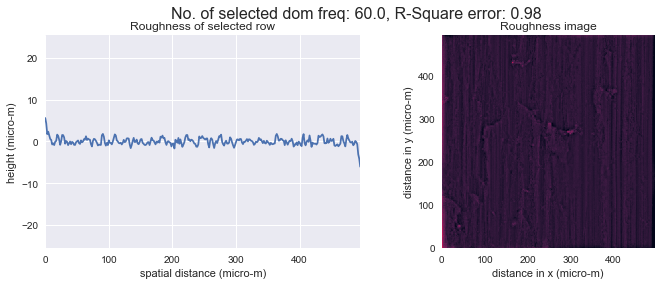

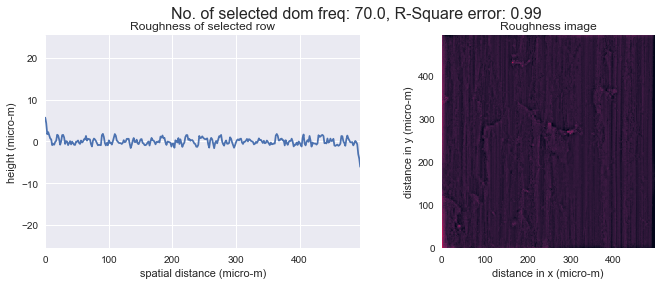

In [83]:
# find result error between roughness and extracted surface

for i in tqdm(range(len(no_dom_freq_per))):
    df_dom_samp.loc[i,'result_error'] = find_error_dom_f(df_dom_samp.loc[i,'no_f_per'], df_dom_samp.loc[i,'f_dom_amp_c'])
    
df_dom_samp

In [84]:
# automatically assign cut-off dominant amplitude by acceptable percentage of error

for i in range(len(no_dom_freq_per)):
    if df_dom_samp.loc[i,'result_error'] > accept_dom_rSqua_2D:
        freq_dom_amp_c_2D = df_dom_samp.loc[i,'f_dom_amp_c']
        break
            
freq_dom_amp_c_2D

134.65195289231625

### Extraction operation

In [85]:
# remain only dominant freq in matrix

df_freq_dom = df_freq.copy()
    
for x in df_freq.columns:
    df_freq_dom[x] = np.where(
        df_freq_amp[x] > freq_dom_amp_c_2D,
        df_freq_dom[x],
        0.0
    )

In [86]:
z_fou_dom = df_freq_dom.values
z_inv_dom_2D = ifft2(z_fou_dom)

z_fou_dom_shift = fftshift(z_fou_dom)
z_fou_dom_ishift = ifftshift(z_fou_dom_shift)

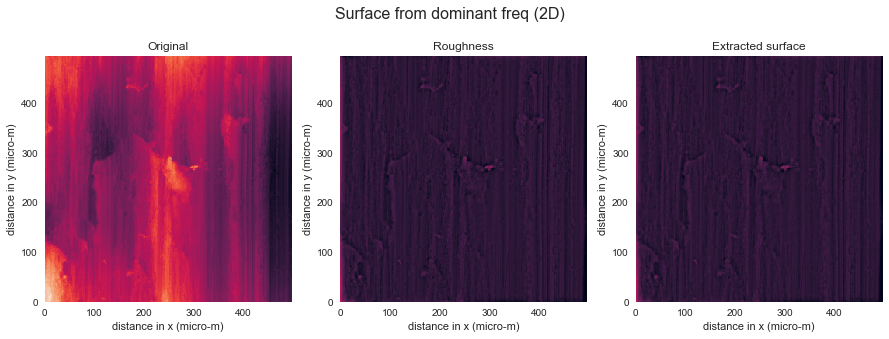

In [87]:
# plot surface image

plot_size = (15, 5)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=plot_size)
f.suptitle("Surface from dominant freq (2D)", fontsize=16)

ax1.imshow(z_inv_smooth_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Original')
ax1.grid(False)

ax2.imshow(z_inv_high_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Roughness')
ax2.grid(False)

ax3.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist) 
ax3.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax3.title.set_text('Extracted surface')
ax3.grid(False)

D:\Program\Python\lib\site-packages\matplotlib\transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


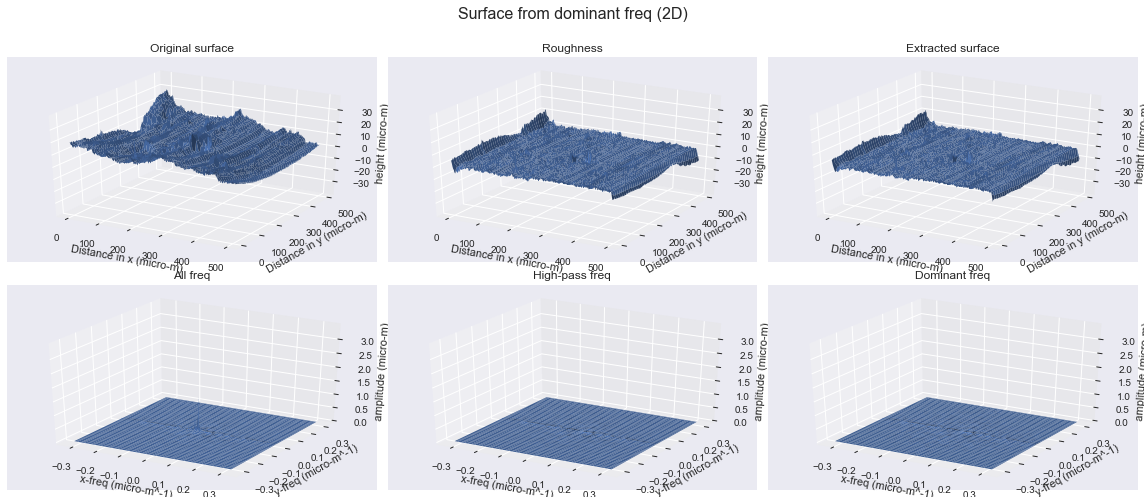

In [88]:
# plot surface 3D

plot_size = (16, 7)
fig = plt.figure(figsize=plot_size)
fig.suptitle('Surface from dominant freq (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(2, 3, 1, projection='3d') 

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Original surface')


# Second subplot
ax = fig.add_subplot(2, 3, 2, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


# third subplot
ax = fig.add_subplot(2, 3, 3, projection='3d')

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-plt_dist_zlim_2D, plt_dist_zlim_2D)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Extracted surface')


# fourth subplot
ax = fig.add_subplot(2, 3, 4, projection='3d')          

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_smooth_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('All freq')


# fifth subplot
ax = fig.add_subplot(2, 3, 5, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_high_2D)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('High-pass freq')


# sixth subplot
ax = fig.add_subplot(2, 3, 6, projection='3d')

X = freq_full_shift
Y = freq_full_shift
X, Y = np.meshgrid(X, Y)
Z = 1/data_pnts**2 * abs(z_fou_dom_shift)

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(0, plt_freq_zlim_2D * 0.3)
ax.set(xlabel='x-freq (micro-m^-1)', ylabel='y-freq (micro-m^-1)', zlabel='amplitude (micro-m)')
ax.title.set_text('Dominant freq')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [89]:
# count amount of dominant freq
f_dom_no = (df_freq_dom != 0).astype(int).values.sum()

print('Amount of dominant freq: ', f_dom_no)

Amount of dominant freq:  30337


In [90]:
# compare result 

rSq_rou2dom_2D = r2_score(z_inv_high_2D.real, z_inv_dom_2D.real)

print('Roughness to Dominant surface 2D')
print('R-square: ', rSq_rou2dom_2D)

Roughness to Dominant surface 2D
R-square:  0.9204741393077851


# Import data to csv file

## 1D import file

### Variables of full-frequency

In [91]:
df_excel_1D = df_freq_dom_1D[['freq', 'high_conv', 'amplitude', 'dominant?']].copy()

# keep only rows with dominant freq
df_excel_1D = df_excel_1D[(df_excel_1D[['dominant?']] == True).any(axis=1)]
df_excel_1D = df_excel_1D.reset_index(drop=True)

In [92]:
df_excel_1D = df_excel_1D.drop(['dominant?'], axis=1)
df_excel_1D = df_excel_1D.rename(index=str, columns={'freq':'f(um)^-1', 
                                                     'high_conv':'FourierCoef', 
                                                     'amplitude':'A(um)'
                                                    })

df_excel_1D['FourierCoef'] = df_excel_1D['FourierCoef'] / data_pnts
df_excel_1D['Phs(rad)'] = np.angle(df_excel_1D['FourierCoef'])

### Variables of half-frequency

In [93]:
# keep only positive freq

df_excel_1D_pos = df_excel_1D.copy()
df_excel_1D_pos = df_excel_1D_pos[(df_excel_1D_pos[['f(um)^-1']] >= 0).any(axis=1)]
df_excel_1D_pos = df_excel_1D_pos.reset_index(drop=True)

In [94]:
# correct the amplitude by *2

f_dom_no_1D_pos = int(f_dom_no_1D/2)

df_excel_1D_pos['FourierCoef'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['FourierCoef'],
    2 * df_excel_1D_pos['FourierCoef']
)

df_excel_1D_pos['A(um)'] = np.where(
    df_excel_1D_pos['f(um)^-1'] == 0,
    df_excel_1D_pos['A(um)'],
    2 * df_excel_1D_pos['A(um)']
)

df_excel_1D_pos.head()

f(um)^-1                                   FourierCoef     A(um)  Phs(rad)
0  0.004025  (0.017455238823101068-0.028566245617556812j)  0.033477 -1.022296
1  0.006038  (-0.025280669766987163-0.02306369304100173j)  0.034221 -2.402020
2  0.008050    (0.00948947028034561-0.05208354388651176j)  0.052941 -1.390576
3  0.010063    (-0.01572450273349393-0.0550617828322838j)  0.057263 -1.848971
4  0.012075     (0.0110512758770316-0.10301731860379268j)  0.103608 -1.463929

In [95]:
print('Amount of dominant freq (full): ', f_dom_no_1D)
print('Amount of dominant freq (half): ', f_dom_no_1D_pos)

Amount of dominant freq (full):  287
Amount of dominant freq (half):  143


In [96]:
# # import dataframe to csv

# df_excel_1D_pos.to_csv('onefile_variables_1D.csv', index=False)

### Height of dominant surface

In [97]:
df_excel_1D_z_dom = pd.DataFrame(data = data_list, columns = ['x(um)'])
df_excel_1D_z_dom['z(um)'] = z_inv_dom_1D.real

df_excel_1D_z_dom.head()

x(um)     z(um)
0  0.0000  5.684546
1  1.5625  4.399390
2  3.1250  1.742721
3  4.6875  2.261666
4  6.2500  1.384953

In [98]:
# # cut length of imported height as assign

# if assign_csv_len == 'y':
#     df_excel_1D_z_dom = df_excel_1D_z_dom.iloc[0:csv_len_1D]

# print('Processed length: ', data_pnts)
# print('Imported length:  ', len(df_excel_1D_z_dom))

In [99]:
# # import dataframe to csv

# df_excel_1D_z_dom.to_csv('onefile_height_1D.csv', index=False)

## 2D import file

### Variables of full-frequency

In [100]:
df_freq_dom = pd.DataFrame(data = z_fou_dom_ishift)

# assign index to dataframe
df_freq_dom.index = freq_full
df_freq_dom.columns = freq_full

In [101]:
# unpivot table of df_freq_dom

df_excel_2D = df_freq_dom.unstack().reset_index(name='FourierCoef')
df_excel_2D.rename(columns={'level_0': 'fx(um)^-1', 'level_1': 'fy(um)^-1'}, inplace=True)

In [102]:
# assign amplitude and phase

df_excel_2D['FourierCoef'] = df_excel_2D['FourierCoef'] / data_pnts**2
df_excel_2D['A(um)'] = np.abs(df_excel_2D['FourierCoef'])
df_excel_2D['Phs(rad)'] = np.angle(df_excel_2D['FourierCoef'])


# remain only dominant freq

df_excel_2D = df_excel_2D[(df_excel_2D[['FourierCoef']] != 0).any(axis=1)]
df_excel_2D = df_excel_2D.reset_index(drop=True)

### Variables of half-frequency

In [103]:
# remain only freq in half positive quarters

df_excel_2D_half = df_excel_2D.copy()
df_excel_2D_half = df_excel_2D_half[(df_excel_2D_half[['fx(um)^-1']] >= 0).any(axis=1)]
df_excel_2D_half = df_excel_2D_half.reset_index(drop=True)

In [104]:
# correct the amplitude by *2

f_dom_no_half = len(df_excel_2D_half)

df_excel_2D_half['FourierCoef'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['FourierCoef'],
    2 * df_excel_2D_half['FourierCoef']
)

df_excel_2D_half['A(um)'] = np.where(
    df_excel_2D_half['fx(um)^-1'] == 0,
    df_excel_2D_half['A(um)'],
    2 * df_excel_2D_half['A(um)']
)

df_excel_2D_half.head()

fx(um)^-1  fy(um)^-1                                      FourierCoef  \
0        0.0   0.002013   (0.0032301724777363747+9.973272474594726e-05j)   
1        0.0   0.004025    (0.005443450361394661-0.0004914894211969843j)   
2        0.0   0.006038   (7.896567523778294e-05-0.0014314858221334181j)   
3        0.0   0.008050    (0.004471065988665688-0.0018730231561438285j)   
4        0.0   0.010063  (-0.0009625774223959425-0.0031375237464358902j)   

      A(um)  Phs(rad)  
0  0.003232  0.030866  
1  0.005466 -0.090046  
2  0.001434 -1.515689  
3  0.004848 -0.396710  
4  0.003282 -1.868476

In [105]:
print('Amount of dominant freq (full): ', f_dom_no)
print('Amount of dominant freq (half): ', f_dom_no_half)

Amount of dominant freq (full):  30337
Amount of dominant freq (half):  15300


In [106]:
# # import dataframe to csv

# df_excel_2D_half.to_csv('onefile_variables_2D.csv', index=False)

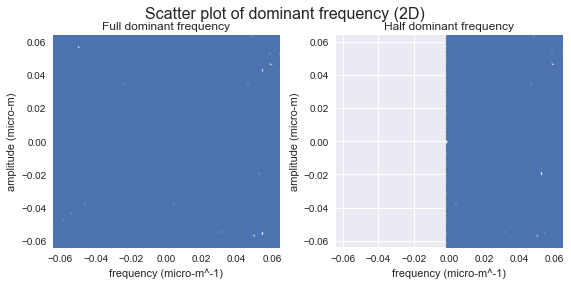

In [107]:
# scatter plot to compare full & half dominant freq

axis_freq = (0, samp_rate, 0, samp_rate)

plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Scatter plot of dominant frequency (2D)", fontsize=16)


## plot1
data = df_excel_2D[['fx(um)^-1', 'fy(um)^-1']].values
x1, y1 = data.T

ax1.scatter(x1,y1)
ax1.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax1.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax1.title.set_text('Full dominant frequency')


## plot2
data = df_excel_2D_half[['fx(um)^-1', 'fy(um)^-1']].values
x2, y2 = data.T

ax2.scatter(x2,y2)
ax2.set_xlim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set_ylim((-samp_rate * 0.1, samp_rate * 0.1))
ax2.set(xlabel='frequency (micro-m^-1)', ylabel='amplitude (micro-m)')
ax2.title.set_text('Half dominant frequency')


plt.tight_layout()
f.subplots_adjust(top=0.88)

### Height of dominant surface

In [108]:
df_excel_2D_z_dom = pd.DataFrame(data = z_inv_dom_2D.real, columns = data_list)
df_excel_2D_z_dom.index = data_list

df_excel_2D_z_dom.iloc[0:5,0:5]

0.0000    1.5625    3.1250    4.6875    6.2500
0.0000  6.143649  3.585565  1.015773 -0.427029 -2.014394
1.5625  4.728288  2.083970  0.160399 -0.886098 -3.012096
3.1250  5.009556  2.948399  0.911541  0.527926 -0.875969
4.6875  5.183250  3.904545  1.638617  1.362000  0.439046
6.2500  5.089201  4.366947  1.773976  1.219174  0.615226

In [109]:
# # cut length of imported height as assign

# if assign_csv_len == 'y':
#     df_excel_2D_z_dom = df_excel_2D_z_dom.iloc[
#         int(data_pnts/2):int(data_pnts/2+csv_len_2D), int(data_pnts/2):int(data_pnts/2+csv_len_2D)]

# print('Processed length: ', data_pnts)
# print('Imported length:  ', len(df_excel_2D_z_dom))

In [110]:
# # unpivot table

# temp = df_excel_2D_z_dom.stack()
# df_excel_2D_z_dom_melt = pd.DataFrame(temp)
# df_excel_2D_z_dom_melt.columns = ['z']
# df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.reset_index()
# df_excel_2D_z_dom_melt = df_excel_2D_z_dom_melt.rename(index=str, columns={'level_0': 'x',
#                                                                            'level_1': 'y'})

# df_excel_2D_z_dom_melt.head()

In [111]:
# # rearrange data
# shiftValue = df_excel_2D_z_dom_melt.iloc[0,0]

# df_excel_2D_z_dom_melt['x'] = df_excel_2D_z_dom_melt['x'] - shiftValue - data_len_recon/2
# df_excel_2D_z_dom_melt['y'] = df_excel_2D_z_dom_melt['y'] - shiftValue - data_len_recon/2
# df_excel_2D_z_dom_melt['z'] = df_excel_2D_z_dom_melt['z']
# df_excel_2D_z_dom_melt.columns = ['z', 'x', 'y']

# df_excel_2D_z_dom_melt.head()

In [112]:
# # import dataframe to csv

# df_excel_2D_z_dom_melt.to_csv('onefile_height_2D.csv', index=False)

# Surface reconstruction

## 1D surface reconstruction

In [113]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_1D_pos = np.zeros(data_pnts_recon)
x = np.array(data_list_recon)

for i in tqdm(range(f_dom_no_1D_pos)):
    
    A = df_excel_1D_pos['A(um)'].iloc[i]
    f = df_excel_1D_pos['f(um)^-1'].iloc[i]
    ph = df_excel_1D_pos['Phs(rad)'].iloc[i]
        
    zi = A * np.cos(2*np.pi*f*x + ph)
    z_recon_1D_pos = z_recon_1D_pos + zi
    
z_recon_1D_pos[0:5]

100%|█████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 15939.87it/s]


array([5.65832009, 2.72389026, 2.4504408 , 1.43965286, 0.69344316])

In [114]:
df_1D_z_recon = pd.DataFrame(data = data_list_recon, columns = ['x'])
df_1D_z_recon['z'] = z_recon_1D_pos.real

df_1D_z_recon.head()

x         z
0  0.0  5.658320
1  2.0  2.723890
2  4.0  2.450441
3  6.0  1.439653
4  8.0  0.693443

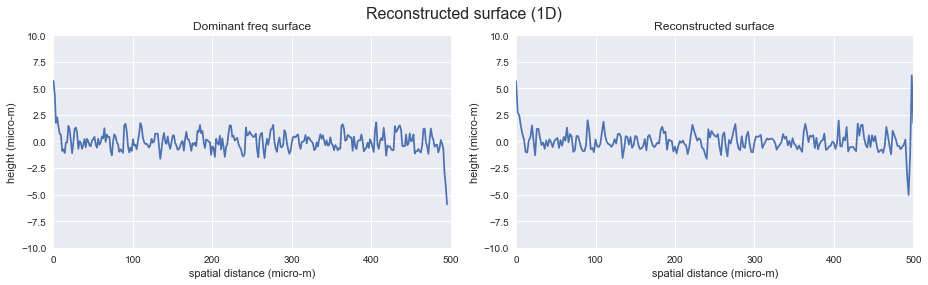

In [115]:
plot_size = (13, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (1D)", fontsize=16)

ax1.plot(data_list, z_inv_dom_1D.real)
ax1.set_xlim(0, data_len_recon)
ax1.set_ylim(-10, 10)
ax1.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax1.title.set_text('Dominant freq surface')

ax2.plot(data_list_recon, z_recon_1D_pos)
ax2.set_xlim(0, data_len_recon)
ax2.set_ylim(-10, 10)
ax2.set(xlabel='spatial distance (micro-m)', ylabel='height (micro-m)')
ax2.title.set_text('Reconstructed surface')

plt.tight_layout()
f.subplots_adjust(top=0.88)

In [116]:
# # import dataframe to csv

# df_1D_z_recon.to_csv('1D_recon_WireCut2_1.csv', index=False)

In [117]:
# # compare result

# rSq_dom2recon_1D = r2_score(z_inv_dom_1D.real, z_recon_1D_pos)
# rSq_rou2recon_1D = r2_score(z_inv_high_1D.real, z_recon_1D_pos)

# print('Dominant to reconstructed surface 1D')
# print('R-square: ', rSq_dom2recon_1D)
# print('\nRoughness to reconstructed surface 1D')
# print('R-square: ', rSq_rou2recon_1D)

## 2D surface reconstruction

In [118]:
# reconstruct surface by superposition of sinusoidal wave

z_recon_2D_half = pd.DataFrame(np.zeros((data_pnts_recon, data_pnts_recon)))
x, y = np.meshgrid(data_list_recon, data_list_recon)

for i in tqdm(range(f_dom_no_half)):
    
    A = df_excel_2D_half['A(um)'].iloc[i]
    fx = df_excel_2D_half['fx(um)^-1'].iloc[i]
    fy = df_excel_2D_half['fy(um)^-1'].iloc[i]
    ph = df_excel_2D_half['Phs(rad)'].iloc[i]
    
    zi = A * np.cos(2*np.pi*(fx*x + fy*y) + ph)
    z_recon_2D_half = z_recon_2D_half + zi
    
z_recon_2D_half.iloc[0:5,0:5]

100%|███████████████████████████████████████████████████████████████████████████| 15300/15300 [00:20<00:00, 758.32it/s]


0         1         2         3         4
0  6.130605  1.742849  0.958554 -2.039971 -3.633086
1  4.789501  0.807310  0.776091 -2.184861 -3.553926
2  5.106689  1.989778  1.550933 -0.045885 -1.151798
3  5.056475  2.916035  1.864806  0.599296 -0.183701
4  5.630840  3.108722  2.200035  1.111569  0.322437

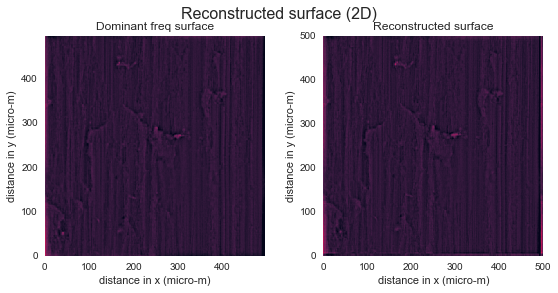

In [119]:
plot_size = (8, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)
f.suptitle("Reconstructed surface (2D)", fontsize=16)

ax1.imshow(z_inv_dom_2D.real, extent=axis_dist, vmin=v_min_dist, vmax=v_max_dist)
ax1.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax1.title.set_text('Dominant freq surface')
ax1.grid(False)

ax2.imshow(z_recon_2D_half.values.real, extent=axis_dist_recon, vmin=v_min_dist, vmax=v_max_dist) 
ax2.set(xlabel='distance in x (micro-m)', ylabel='distance in y (micro-m)')
ax2.title.set_text('Reconstructed surface')
ax2.grid(False)

plt.tight_layout()
f.subplots_adjust(top=0.88)

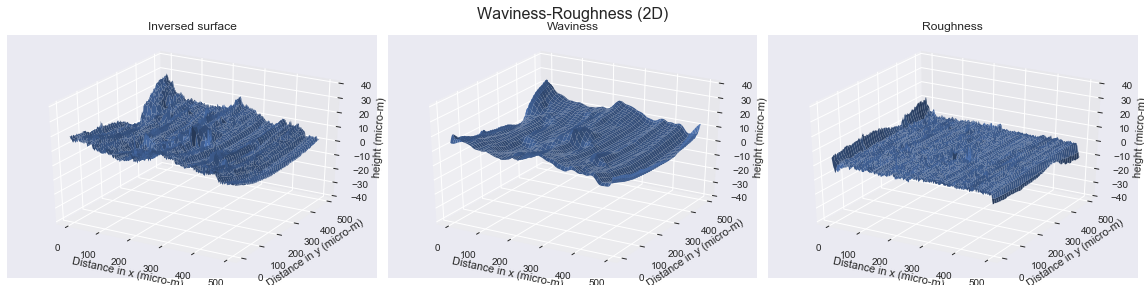

In [120]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Waviness-Roughness (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_smooth_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Inversed surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_low_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Waviness')


# third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')            

X = data_list
Y = data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [121]:
# prepare axis for surface plot

plot_max_loc = 0

for i in range(len(data_list)):
    if data_list[len(data_list)-1-i] < elemsize_recon:
        plot_max_loc = len(data_list)-1-i
        break

plot_data_list = x_list[0:plot_max_loc]
        
print(plot_max_loc)
print(data_list[plot_max_loc])

317
495.31199999999995


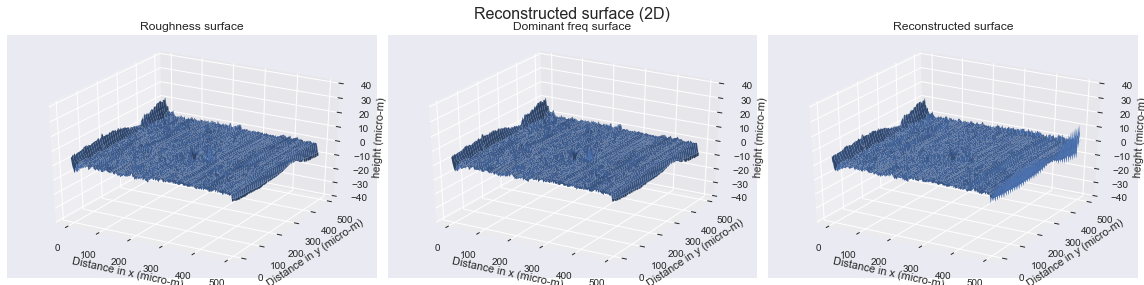

In [122]:
fig = plt.figure(figsize=plt.figaspect(0.25))
fig.suptitle('Reconstructed surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 3, 1, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_high_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Roughness surface')


# Second subplot
ax = fig.add_subplot(1, 3, 2, projection='3d')           

X = plot_data_list
Y = plot_data_list
X, Y = np.meshgrid(X, Y)
Z = z_inv_dom_2D.real
Z = Z[0: plot_max_loc, 0: plot_max_loc]

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Dominant freq surface')


# Third subplot
ax = fig.add_subplot(1, 3, 3, projection='3d')           

X = data_list_recon
Y = data_list_recon
X, Y = np.meshgrid(X, Y)
Z = z_recon_2D_half.values.real

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Reconstructed surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [123]:
# # import dataframe to csv

# z_recon_2D_half.to_csv(fileName2D + '_pivot.csv')

In [124]:
# # compare result

# rSq_dom2recon_2D = r2_score(z_inv_dom_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)
# rSq_rou2recon_2D = r2_score(z_inv_high_2D.real[0: data_pnts_recon, 0: data_pnts_recon], z_recon_2D_half.values.real)

# print('Dominant to reconstructed surface 2D')
# print('R-square: ', rSq_dom2recon_2D)
# print('\nRoughness to reconstructed surface 2D')
# print('R-square: ', rSq_rou2recon_2D)

In [125]:
# unpivot table

temp = z_recon_2D_half.stack()
df2D_recon_melt = pd.DataFrame(temp)
df2D_recon_melt.columns = ['z']
df2D_recon_melt = df2D_recon_melt.reset_index()
df2D_recon_melt = df2D_recon_melt.rename(index=str, columns={'level_0': 'x', 'level_1': 'y'})
df2D_recon_melt.columns = ['x', 'z', 'y']

df2D_recon_melt.head()

x  z         y
0  0  0  6.130605
1  0  1  1.742849
2  0  2  0.958554
3  0  3 -2.039971
4  0  4 -3.633086

In [126]:
# rearrange data

df2D_recon_melt['z'] = df2D_recon_melt['z'] * data_interval_recon
df2D_recon_melt['y'] = df2D_recon_melt['y']
df2D_recon_melt['x'] = df2D_recon_melt['x'] * data_interval_recon

df2D_recon_melt.head()

x    z         y
0  0.0  0.0  6.130605
1  0.0  2.0  1.742849
2  0.0  4.0  0.958554
3  0.0  6.0 -2.039971
4  0.0  8.0 -3.633086

In [127]:
# switch x and z columns for correct load apply

columnsTitles=['z', 'x', 'y']
df2D_recon_melt = df2D_recon_melt.reindex(columns = columnsTitles)

df2D_recon_melt = df2D_recon_melt.sort_values(by=['z', 'x'])

df2D_recon_melt.head()

z    x         y
0     0.0  0.0  6.130605
251   0.0  2.0  4.789501
502   0.0  4.0  5.106689
753   0.0  6.0  5.056475
1004  0.0  8.0  5.630840

### Selected area of reconstructed surface

In [128]:
x_select_end = x_select + elemsize_select
z_select_end = z_select + elemsize_select

In [129]:
df2D_recon_select = df2D_recon_melt.reset_index(drop=True)
df2D_recon_select.head()

z    x         y
0  0.0  0.0  6.130605
1  0.0  2.0  4.789501
2  0.0  4.0  5.106689
3  0.0  6.0  5.056475
4  0.0  8.0  5.630840

In [130]:
# find index for selected area (z select)

select_min_loc = 0
select_max_loc = 0

select_data_list = df2D_recon_select['z'].values

for i in range(len(select_data_list)):
    if select_data_list[i] == z_select:
        select_min_loc = i
        break

for i in range(len(select_data_list)):
    if select_data_list[len(select_data_list)-1-i] == z_select_end:
        select_max_loc = len(select_data_list)-1-i
        break

print(select_min_loc)
print(select_max_loc)

15060
19075


In [131]:
# trim for selected area (z_select)

df2D_recon_select = df2D_recon_select.iloc[select_min_loc: select_max_loc]
df2D_recon_select.head()

z    x         y
15060  120.0  0.0 -1.000130
15061  120.0  2.0 -0.667209
15062  120.0  4.0 -0.715174
15063  120.0  6.0 -0.530810
15064  120.0  8.0 -0.431636

In [132]:
# sort 'x' for trimming
df2D_recon_select = df2D_recon_select.sort_values(by=['x', 'z'])
df2D_recon_select = df2D_recon_select.reset_index(drop=True)
df2D_recon_select.head()

z    x         y
0  120.0  0.0 -1.000130
1  122.0  0.0 -0.881411
2  124.0  0.0 -0.579457
3  126.0  0.0 -0.852616
4  128.0  0.0 -0.305821

In [133]:
# find index for selected area (x select)

select_min_loc = 0
select_max_loc = 0

select_data_list = df2D_recon_select['x'].values

for i in range(len(select_data_list)):
    if select_data_list[i] == x_select:
        select_min_loc = i
        break

for i in range(len(select_data_list)):
    if select_data_list[len(select_data_list)-1-i] == x_select_end:
        select_max_loc = len(select_data_list)-i
        break

print(select_min_loc)
print(select_max_loc)

2000
2256


In [134]:
# trim for selected area (x_select)

df2D_recon_select = df2D_recon_select.iloc[select_min_loc: select_max_loc]
df2D_recon_select.head()

z      x         y
2000  120.0  250.0  0.278633
2001  122.0  250.0  0.454350
2002  124.0  250.0 -0.232860
2003  126.0  250.0 -1.112718
2004  128.0  250.0  0.439358

In [135]:
# final sort and arrange data

df2D_recon_select = df2D_recon_select.sort_values(by=['z', 'x'])
df2D_recon_select = df2D_recon_select.reset_index(drop=True)

df2D_recon_select['z'] = df2D_recon_select['z'] - z_select
df2D_recon_select['x'] = df2D_recon_select['x'] - x_select

df2D_recon_select.head()

z    x         y
0  0.0  0.0  0.278633
1  0.0  2.0  0.123549
2  0.0  4.0  0.364032
3  0.0  6.0  0.356349
4  0.0  8.0  0.130838

In [136]:
# pivot table for graph

select_data_pnts = int((elemsize_select+data_interval_recon)/data_interval_recon)

select_data_list = np.linspace(0, elemsize_select, select_data_pnts)     # numpy.linspace(start, stop, num)
df2D_recon_select_pivot = df2D_recon_select.pivot_table(values='y', index='x', columns='z', aggfunc='first')

print(select_data_list)
df2D_recon_select_pivot.iloc[0:5,0:5]

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30.]


z         0.0       2.0       4.0       6.0       8.0
x                                                    
0.0  0.278633  0.454350 -0.232860 -1.112718  0.439358
2.0  0.123549  0.842214 -0.087291 -1.145965  0.501404
4.0  0.364032  0.685985 -0.357341 -0.844586  0.493366
6.0  0.356349  0.985133 -0.202540 -0.759555  0.513030
8.0  0.130838  0.956813 -0.422383 -0.783906  0.162514

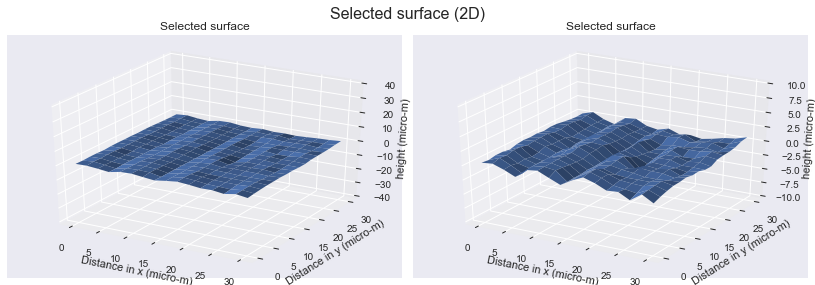

In [137]:
fig = plt.figure(figsize=plt.figaspect(0.35))
fig.suptitle('Selected surface (2D)', fontsize=16)


# First subplot
ax = fig.add_subplot(1, 2, 1, projection='3d')           

X = select_data_list
Y = select_data_list
X, Y = np.meshgrid(X, Y)
Z = df2D_recon_select_pivot

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-40, 40)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Selected surface')


# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d') 

X = select_data_list
Y = select_data_list
X, Y = np.meshgrid(X, Y)
Z = df2D_recon_select_pivot

surf = ax.plot_surface(X, Y, Z)
ax.set_zlim(-10, 10)
ax.set(xlabel='Distance in x (micro-m)', ylabel='Distance in y (micro-m)', zlabel='height (micro-m)')
ax.title.set_text('Selected surface')


plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

In [138]:
# prepare file name

elemForName = '_' + str(elemsize_select) + 'um'

pntForName = '_' + str(select_data_pnts) + 'pnts'

trimForName = '_trim' + str(trim_min) + '-' + str(trim_max)

selectForName = '_x' + str(x_select) + 'z' + str(z_select)

outputFileName = 'recon2D_' + input_file[:-4] + elemForName + pntForName + trimForName + selectForName + '_' + charactSurf

print(outputFileName)

recon2D_Drill3_1_30um_16pnts_trim400-900_x250z120_roughness


In [139]:
# import dataframe to csv (reconstructed surface)

df2D_recon_select.to_csv(outputFileName + '.csv', index=False)